1. Loading models and Sampling: this notebook we will use logistic regression to predict likelihood of default.

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv(r'C:\\Users\dongw\OneDrive\Documents\2. Programming\Springboard\DS\Lending Club Loan\data\train_df2.csv')
test = pd.read_csv(r'C:\\Users\dongw\OneDrive\Documents\2. Programming\Springboard\DS\Lending Club Loan\data\test_df2.csv')

In [3]:
#separte X, y in training and test
X_train = train.drop('Default', axis=1)
y_train = train['Default']
X_test = test.drop('Default', axis=1)
y_test = test['Default']

In [4]:
#feature 'totalR_rec_prncp'Principal received to date, will be dropped before proceeding, because it was found dominant 
# for contributing default, one reason is that as long as the principle received to date is not met the loan repay, it is highly
# prone that the model believe there are very 'default' type.

train.drop(columns=['total_rec_prncp', 'total_rec_int'], inplace = True)
test.drop(columns=['total_rec_prncp', 'total_rec_int'], inplace = True)

In [5]:
#check class number
default = train[train.Default == 1]
no_default = train[train.Default == 0]
ratio = default.shape[0]/no_default.shape[0]
ratio

0.2642572077581688

In [6]:
#downsample the training data, to balance class labels

from imblearn.under_sampling import RandomUnderSampler
#sampling_strategy = 1
under = RandomUnderSampler()
X_dn, y_dn = under.fit_resample(X_train, y_train)
print(X_dn.shape, X_train.shape)
y_dn = pd.DataFrame(y_dn, columns = ['Default'])
y_dn.Default.value_counts()

(378086, 86) (904418, 86)


0    189043
1    189043
Name: Default, dtype: int64

In [7]:
#combine downsized X, y into one dataframe

new_train = pd.concat([X_dn, y_dn],axis=1)

In [8]:
#shuffle the data before creating the subsamples, with 0.1 fraction, after subsampling it is still chanlleging to run in local
#I decided to run with 1/10 sample after downsampling 

new_train = new_train.sample(frac = 0.1, random_state=42)

In [9]:
X_train = new_train.drop('Default', axis=1)
y_train = new_train['Default']

2. Logistic Regression 

In [10]:
%%time
#define the model and hyperparameters

model = LogisticRegression(random_state=40)

penalty = ['l1','l2']
c_values = [100, 10, 1.0, 0.1]
solvers = ['newton-cg','liblinear']

# define grid search
grid = dict(solver=solvers,
            penalty=penalty,
            C=c_values)

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=1)

grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='average_precision',error_score=0)

grid_result = grid_search.fit(X_train, y_train)

Wall time: 4min 56s


In [11]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.999302 using {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'l1', 'solver': 'newton-cg'}
0.999271 (0.000151) with: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.999279 (0.000154) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.999276 (0.000156) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 10, 'penalty': 'l1', 'solver': 'newton-cg'}
0.999289 (0.000160) with: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
0.999188 (0.000165) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.999190 (0.000168) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 1.0, 'penalty': 'l1', 'solver': 'newton-cg'}
0.999302 (0.000196) with: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
0.998876 (0.000189) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.998893 (0.000193) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.000000

In [15]:
# model with best parameter

lr = LogisticRegression(solver = 'liblinear', 
                        penalty='l1',
                        C =1.0,
                        random_state=40,)

In [16]:
%%time
result = lr.fit(X_train, y_train)

Wall time: 20.9 s


In [17]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score

def result(model, X_test, y_test, clf_name):
    """ This function calculates different metrics to show the model's performance on both training and test data.
    This functoin also shows the confusion matrix, and plots the ROC and PR curves.
    
    Parameters
    ----------
    model (dtype: sklearn.model_selection._search.GridSearchCV) : The classifier model
    train_result (dtype: boolean): If YES, calculate results for train data
    clf_name (dtype: str): Name of the classifier
    """    
    y_pred_test = model.predict(X_test)
    y_pred_test_prob = model.predict_proba(X_test)
    y_score = model.predict_proba(X_test)[:, 1]
    print("#####################")
    print("Test data")
    print("#####################")
    print("F1: ", metrics.f1_score(y_test, y_pred_test))
    print("PR AUC: ", average_precision_score(y_test, y_score)) ##average_precision equal to PR AUC
    print('ROC_AUC: ',roc_auc_score(y_test, y_score))
    print("LogLoss: ", metrics.log_loss(y_test, y_pred_test_prob))
    print(metrics.classification_report(y_test, y_pred_test))

In [18]:
result(lr, X_test, y_test, clf_name="F1, PR AUC")

#####################
Test data
#####################
F1:  0.9915162008409598
PR AUC:  0.9973777728188882
ROC_AUC:  0.9991339716750893
LogLoss:  0.03805296186476304
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    306591
           1       0.99      0.99      0.99     81018

    accuracy                           1.00    387609
   macro avg       1.00      0.99      0.99    387609
weighted avg       1.00      1.00      1.00    387609



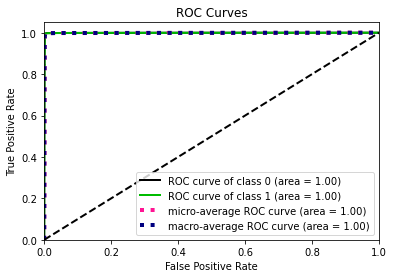

In [19]:
probs = grid_result.predict_proba(X_test)
import matplotlib.pyplot as plt
import scikitplot as skplt
skplt.metrics.plot_roc(y_test, probs)
plt.show()

In [20]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
y_score = lr.decision_function(X_test)

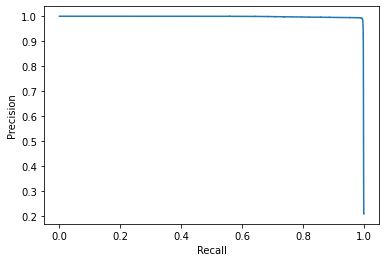

In [23]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

prec, recall, _ = precision_recall_curve(y_test, y_score,
                                         pos_label=lr.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()